# `photoeccentric` sensitivitiy tests

This notebook sets up a sensitivity test for `photoeccentric` to determine how accurately it recovers eccentricity with simulated transits. In general, this is also how I would structure the code to recover eccentricities for a large number of planets in sequence.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from astropy.table import Table
import astropy.units as u

# Using `batman` to create & fit fake transit
import batman

# Using astropy BLS and scipy curve_fit to fit transit
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.optimize as opt

# Using emcee & corner to find and plot (e, w) distribution
import emcee
import corner

# And importing `photoeccentric`
import photoeccentric as ph

# Random stuff
import scipy.constants as c
import os

%load_ext autoreload
%autoreload 2

%matplotlib inline

plt.rcParams['figure.figsize'] = [12, 8]

I'll fit the transits with `emcee`, which takes a number of walkers, steps, and steps to discard. I'm defining them here so I can create my planet parameter distributions (period, rp/rs, a/rs, inclination) to be the proper length.

In [4]:
nwalk = 64
nsteps_d = 3000
ndiscard_d = 1000
arrlen = (nsteps_d-ndiscard_d)*nwalk

In [5]:
smass_kg = 1.9885e30  # Solar mass (kg)
srad_m = 696.34e6 # Solar radius (m)

## Reading in Sample Data

To run with Kepler light curves, determine the stellar mass and radius from any sources. Here I'm compiling a table of the stellar parameters from the NASA exoplanet archive, adding the stellar data from spectroscopy (Muirhead et al. 2013) and luminosities from Gaia, and using ph.fit_isochrone_lum() to fit stellar isochrones to these data. The mass, mass error, radius, and radius error of the fit isochrones will produce my mass + radius distributions which I will use to determine the stellar density distribution.

In [6]:
muirhead_data = pd.read_csv("datafiles/Muirhead2013_isochrones/muirhead_data_no_missing_data.txt", sep=" ")

# ALL Kepler planets from exo archive
planets = pd.read_csv('datafiles/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets in Muirhead et al. 2013 sample
spectplanets = planets[planets['kepid'].isin(list(muirhead_data['KIC']))]
spectplanets = spectplanets.reset_index()

# Kepler-Gaia Data
kpgaia = Table.read('datafiles/Kepler-Gaia/kepler_dr2_4arcsec.fits', format='fits').to_pandas();

# Kepler-Gaia data for only the objects in our sample
muirhead_gaia = kpgaia[kpgaia['kepid'].isin(list(muirhead_data.KIC))]
muirhead_gaia = muirhead_gaia.reset_index()
muirhead_gaia.rename(columns={"index": "KIC"})

# Combined spectroscopy data + Gaia/Kepler data for our sample
muirhead_comb = pd.concat([muirhead_data, muirhead_gaia], axis=1)
muirhead_comb_nn = muirhead_comb[muirhead_comb.KOI.notnull()]

# Only targets from table above with published luminosities from Gaia
muirhead_comb_lums = muirhead_comb_nn[muirhead_comb_nn.lum_val.notnull()]

# Read in MESA isochrones
isochrones = pd.read_csv('datafiles/Muirhead2013_isochrones/isochrones_sdss_spitzer_lowmass.dat', sep='\s\s+', engine='python')

/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err1' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: TableReplaceWarning: converted column 'teff_err2' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


## Outline for Sensitivity Test

1. Define "test planet" parameters. These parameters will come from a real Kepler planet, but I'll use a fake light curve. These "test planet" parameters will stay the same across the entire test.
2. Write two functions: one that wraps the entire light curve initialization process, and one that wraps the transit fit and eccentricity estimation.
3. For each eccentricity recovered, take the difference between the input e and the peak of the e distribution as the error.
4. Plot on a heatmap

#### Defining a "test planet"

In [87]:
# Kepler ID for Kepler-1582 b
kepid = 5868793
kepname = spectplanets.loc[spectplanets['kepid'] == kepid].kepler_name.values[0]

kp1582b = muirhead_comb.loc[muirhead_comb['KIC'] == kepid]

In [88]:
# ph.fit_isochrone_lum() steps through all MESA isochrones and matches the ones that fit the given parameters
iso_lums = ph.fit_isochrone_lum(kp1582b, muirhead_comb, isochrones, gaia_lum=True)

# Write to csv, then read back in (keeps python notebook from crashing)
iso_lums.to_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

100%|██████████| 738479/738479 [01:10<00:00, 10525.96it/s]


In [89]:
isodf = pd.read_csv("datafiles/isochrones/iso_lums_" + str(kepid) + ".csv")

mstar = isodf["mstar"].mean()
mstar_err = isodf["mstar"].std()

rstar = isodf["radius"].mean()
rstar_err = isodf["radius"].std()

In [90]:
rho_star, mass, radius = ph.find_density_dist_symmetric(mstar, mstar_err, rstar, rstar_err, arrlen)

Text(0.5, 1.0, 'Stellar Density (KIC 5868793) [kg m^-3]')

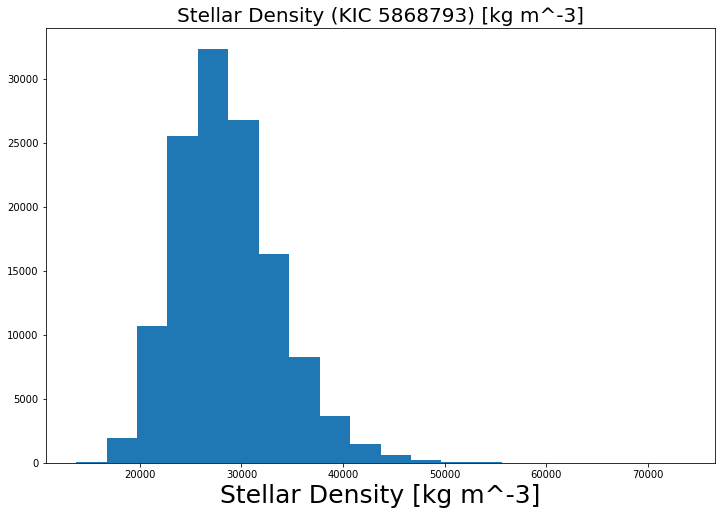

In [91]:
plt.hist(rho_star, bins=20)
plt.xlabel("Stellar Density [kg m^-3]", fontsize=25)
plt.title("Stellar Density (KIC 5868793) [kg m^-3]", fontsize=20)

In [92]:
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a_arc, a_uerr_arc, a_lerr_arc, i, e_arc, w_arc = ph.planet_params_from_archive(spectplanets, kepname)

# We calculate a_rs to ensure that it's consistent with the spec/Gaia stellar density.
a_rs = ph.calc_a(period*86400.0, mstar*smass_kg, rstar*srad_m)
a_rs_err = np.mean((a_uerr_arc, a_lerr_arc))

print('Stellar mass (Msun): ', mstar, 'Stellar radius (Rsun): ', rstar)
print('Period (Days): ', period, 'Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

Stellar mass (Msun):  0.18620280162489727 Stellar radius (Rsun):  0.21038847941706276
Period (Days):  4.83809469 Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98


##### Calculate A_rs prior:

In [93]:
pdist = np.random.normal(period, np.mean((abs(period_uerr), abs(period_lerr))), len(rho_star))

a_rs_gaia = ph.get_a_rs(rho_star, pdist)
a_rs_gaia_sigmin, a_rs_gaia_sigpls = ph.get_sigmas(a_rs_gaia)

a_rs_guess = np.mean(a_rs_gaia)

#a/Rs priors to put in transit fitting
a_rs_priors = [a_rs_guess-10*np.std(a_rs_gaia), a_rs_guess+10*np.std(a_rs_gaia)]

# Using photo_init and photo_fit

In [94]:
# e and w drawn randomly from unifrom distribution

n = 10

e_rand = np.random.uniform(0.0, 1.0, size=n)
w_rand = np.random.uniform(-90.0, 90.0, size=n)

In [95]:
# initialize arrays w zeros

gmeans = np.zeros(n)
gsigs = np.zeros(n)
es_best = np.zeros(n)
ws_best = np.zeros(n)
zscores = np.zeros((n, 2))

This cell measures (e,w) for n synthetic transits. All transits assume the exact same system (both stellar and planet parameters), except for e and w. Here I am simulating Kepler-1582b over and over with different (e,w) each time, and seeing if photoeccentric recovers the correct values.

`zscores` is a list of length 2. Index 0 is the zscore of the fit eccentricity compared to the true eccentricity. Index 1 is the zscore of the fit w compared to the true w. This isn't a good way to do this but ehhh idk yet

`direct` needs to be set as the directory where you want plots to be saved

In [96]:
print('Period (Days): ', period)
print('Rp/Rs: ', rprs)
print('a/Rs: ', a_rs)
print('i (deg): ', i)

for j in range(n):
    print('e: ', e_rand[j], 'w: ', w_rand[j])
    
    dr = 'e_' + str(e_rand[j]) + '_w_' + str(w_rand[j])
    direct = 'plots/' + dr + '/'
    
    if not os.path.exists(direct):
        os.mkdir(direct)
    
    ttime = np.linspace(-24, 24, 10000)
    tflux, tflux_err = ph.photo_init(ttime, period, rprs, a_rs, e_rand[j], i, w_rand[j], noise=0.00005)

    # nsteps kept 1000, nwalkers 32, len(result) 32000
    
    guess_transit = np.array([ph.bls(ttime, tflux), 0.036066, a_rs_guess, 89.9, 90.0])
    guess_ew = np.array([0, 0])
    
    beste, bestw, edist, wdist, gs, g_mean, g_sigmas, zsc = ph.photo_fit(ttime, tflux, tflux_err, guess_transit, guess_ew, rho_star, e_rand[j], w_rand[j], direct, nwalk, nsteps_d, ndiscard_d) 
    gmeans[j] = g_mean
    gsigs[j] = np.mean(g_sigmas)
    es_best[j] = beste
    ws_best[j] = bestw
    zscores[j] = np.mean(zsc)
    print("Best e: ", beste)


Period (Days):  4.83809469
Rp/Rs:  0.036066
a/Rs:  32.64384979582086
i (deg):  89.98
e:  0.09785759870154398 w:  35.355464788308325


100%|██████████| 3000/3000 [06:13<00:00,  8.04it/s]


Fit params:
Period (days):  4.838111935696979
Rp/Rs:  0.036110305491540186
a/Rs:  33.89266564387536
i (deg):  89.712731546028


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 81/5000 [00:00<00:06, 802.12it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 753.98it/s]


Best e:  0.12231715790033322
e:  0.6480601527540535 w:  62.29734112337465


100%|██████████| 3000/3000 [06:58<00:00,  7.16it/s]


Fit params:
Period (days):  4.843401963976149
Rp/Rs:  0.03538673341038335
a/Rs:  61.910952987995024
i (deg):  89.71103420905615


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 82/5000 [00:00<00:06, 817.19it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:10<00:00, 487.22it/s]


Best e:  0.6380134696823648
e:  0.03005597580628039 w:  60.985476096078


100%|██████████| 3000/3000 [08:09<00:00,  6.13it/s]


Fit params:
Period (days):  4.838094630061295
Rp/Rs:  0.036129399766261415
a/Rs:  32.49996920324445
i (deg):  89.61294444587706


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|▏         | 74/5000 [00:00<00:06, 737.86it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 726.11it/s]


Best e:  0.11908591952651038
e:  0.7021016487828395 w:  -52.73290272437051


100%|██████████| 3000/3000 [07:10<00:00,  6.97it/s]


Fit params:
Period (days):  4.838096315709852
Rp/Rs:  0.0360693569206808
a/Rs:  20.0413845820412
i (deg):  89.65656034173907


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 75/5000 [00:00<00:06, 745.62it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 669.64it/s]


Best e:  0.548387231253413
e:  0.05506241144086088 w:  -87.20491605249873


100%|██████████| 3000/3000 [06:25<00:00,  7.78it/s]


Fit params:
Period (days):  4.838097963540782
Rp/Rs:  0.03624151245900331
a/Rs:  29.969768316560423
i (deg):  89.5837120436811


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 148/5000 [00:00<00:06, 722.05it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:06<00:00, 742.15it/s]


Best e:  0.17567516214195622
e:  0.706237294738034 w:  -50.70926975060446


100%|██████████| 3000/3000 [06:21<00:00,  7.86it/s]


Fit params:
Period (days):  4.838073328624384
Rp/Rs:  0.036171577407562105
a/Rs:  20.592362542434046
i (deg):  89.58889281356582


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  3%|▎         | 144/5000 [00:00<00:06, 724.33it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 693.36it/s]


Best e:  0.5337639445308009
e:  0.6702199356041052 w:  -60.776607699488565


100%|██████████| 3000/3000 [07:56<00:00,  6.30it/s]


Fit params:
Period (days):  4.8380922160434
Rp/Rs:  0.03599348466257693
a/Rs:  18.047610893777104
i (deg):  89.57408575795152


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 57/5000 [00:00<00:08, 563.02it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:09<00:00, 520.34it/s]


Best e:  0.6151835317093085
e:  0.6100759538871908 w:  76.28911977600973


100%|██████████| 3000/3000 [08:11<00:00,  6.11it/s]


Fit params:
Period (days):  4.838062483842929
Rp/Rs:  0.036084242347809756
a/Rs:  63.43478277424388
i (deg):  89.81068078387105


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 42/5000 [00:00<00:12, 410.64it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:13<00:00, 379.91it/s]


Best e:  0.6577957443875295
e:  0.5082358863257945 w:  -36.9119097096908


100%|██████████| 3000/3000 [08:39<00:00,  5.77it/s]


Fit params:
Period (days):  4.838106432769731
Rp/Rs:  0.03611972298151908
a/Rs:  25.021423605530913
i (deg):  89.33048280696131


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 51/5000 [00:00<00:09, 501.12it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:08<00:00, 559.69it/s]


Best e:  0.37927746272389207
e:  0.40021796713973445 w:  -20.71114856352183


100%|██████████| 3000/3000 [07:12<00:00,  6.94it/s]


Fit params:
Period (days):  4.838098345951001
Rp/Rs:  0.036090872531052996
a/Rs:  30.01557965254656
i (deg):  89.69512424472687


  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  1%|          | 55/5000 [00:00<00:09, 545.59it/s]

-------MCMC------


100%|██████████| 5000/5000 [00:07<00:00, 626.05it/s]


Best e:  0.17051073218254037


In [97]:
es_best = np.array(es_best)
ws_best = np.array(ws_best)
zscores = np.array(zscores)

np.savetxt('plots/results/32521_2_e_best.csv', es_best, delimiter=',')
np.savetxt('plots/results/32521_2_w_best.csv', ws_best, delimiter=',')
np.savetxt('plots/results/32521_2_e_rand.csv', e_rand, delimiter=',')
np.savetxt('plots/results/32521_2_w_rand.csv', w_rand, delimiter=',')
np.savetxt('plots/results/32521_2_zscores_e.csv', abs(zscores[:,0]), delimiter=',')
np.savetxt('plots/results/32521_2_zscores_w.csv', abs(zscores[:,1]), delimiter=',')

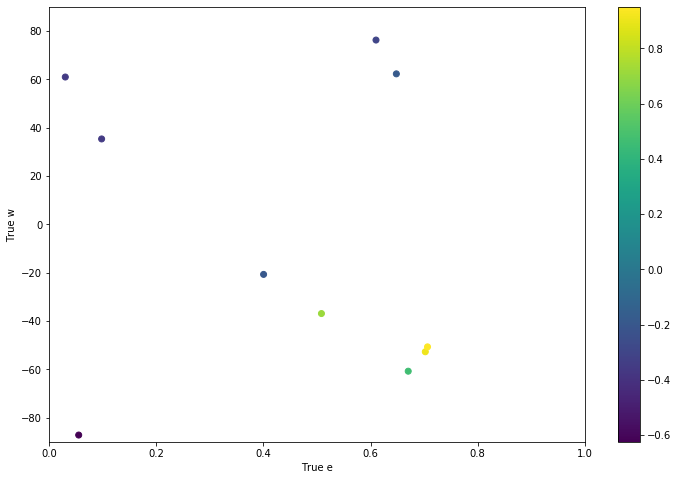

In [98]:
plt.scatter(e_rand, w_rand, c=zscores[:,0])
plt.xlim(0.0, 1.0)
plt.ylim(-90., 90.)
plt.xlabel('True e')
plt.ylabel('True w')
plt.colorbar()

Color corresponds to e error